# Graph network: Node-level classification

In [1]:
## As always
import numpy as np

## ML framework
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch.utils.data import Dataset

## Pytorch geometric: a framework for graph networks
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from torch_geometric.datasets import KarateClub

## Graphical plot and Animation
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import networkx as nx

### Karate Club: Who is your enemy?

Zachary karate club once has 34 members living in harmony. Time flies, the club has been divided into two factions; Admin and Instructor. The members who are close to the admin and the instructor are considered to be on their sides. So, we know whose sides they are, don't we? But machine doesn't know and it will learn who the enemy is.

In [2]:
## Assign roles to nodes: heads of two factions which are Admin and Instructor.
Admin = 0
Instructor = 33

## Load dataset
dataset = KarateClub()
data = dataset.data

In node-level classification, only some nodes are labeled. We train the labeled nodes, then test if the unlabeled nodes will be labeled correctly.

Herein, two nodes which are heads of Admin and Instructor are labeled, and other members will be classified in the test process and compared with the ground truth labeled by us.

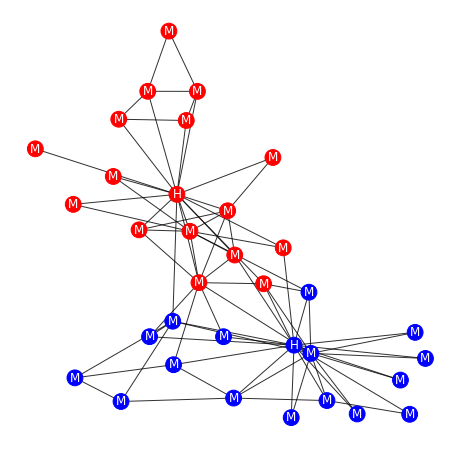

In [3]:
## Mask nodes which are in training set and test set: We train two head nodes and test with member nodes.
train_mask = [1 if i == Admin or i == Instructor else 0 for i in range(0, 34)]
test_mask = [0 if i == Admin or i == Instructor else 1 for i in range(0, 34)]
data.train_mask = torch.tensor(train_mask, dtype=torch.bool)
data.test_mask = torch.tensor(test_mask, dtype=torch.bool)


## To illustrate graphs
def convert_to_networkx(data, train_mask, test_mask):
    G = nx.Graph()
    # Add nodes: A = Administrator, I = Instructor
    node_classes = data.y.to('cpu').numpy()
    G.add_nodes_from([(n, {'community': 'A'}) if node_classes[n] == 0 
                      else (n, {'community': 'I'}) for n in range(len(node_classes))])
    # Add role: H = Head, M = Member
    for n in range(G.number_of_nodes()):
        if train_mask[n]:
            G.nodes[n]['role'] = 'H'
        if test_mask[n]:
            G.nodes[n]['role'] = 'M'
    # Add edges
    edge_indices = data.edge_index.to('cpu').numpy()
    _, num_edges = edge_indices.shape
    for i in range(num_edges):
        G.add_edge(edge_indices[0][i], edge_indices[1][i])
    return G

def show_graph(G):
    nodes = G.nodes()
    labels = nx.get_node_attributes(G, 'role')
    categories = np.array([1 if G.nodes[n]['community'] == 'A' 
                           else 0 if G.nodes[n]['community'] == 'I' else 2 for n in G.nodes()])
    colormap = np.array(['b','r'])
    
    ax.clear()
    pos = nx.spring_layout(G, seed=1362)
    ec = nx.draw_networkx_edges(G, pos, edge_color='k', alpha=0.8)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colormap[categories], 
                                node_size=250, cmap=plt.cm.jet)
    lc = nx.draw_networkx_labels(G, pos, labels=labels, font_color='w')
    
    ax.set_axis_off()

g = convert_to_networkx(data, train_mask, test_mask)
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
show_graph(g)

### Given information

###### PyG data

In [4]:
print(data)

Data(edge_index=[2, 156], test_mask=[34], train_mask=[34], x=[34, 34], y=[34])


###### Ground truth / Target output
Nodes are prior assigned their factions where 0 labels nodes in Admin faction and 1 labels nodes in Intructor faction.

In [5]:
print(data.y)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


Nodes' attributes are one-hot vectors. Size of x is 34x34 where first 34 is a number of nodes and second 34 is a length of one-hot vector.

###### Edges
Edges are relations between pairs of nodes where source-to-destination is a direction of relation. The relation directs in one way called a directed graph, and the relation directs in two ways called an undirected graph.

In [6]:
print('sources:', data.edge_index[0], '\n')
print('destinations:', data.edge_index[1])

sources: tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
         3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
         7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
        13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
        21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
        27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
        31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33]) 

destinations: tensor([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
         3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
         1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
         2,  3,  0,  2, 30, 32, 33,  2

###### Entities and Attributes
Nodes' attributes are one-hot vectors. Size of x is 34x34 where first 34 is a number of nodes and second 34 is a length of one-hot vector.

In [7]:
print('node #1:', data.x[0], '\n')
print('node #3:', data.x[2], '\n')
print(data.x, '\n')
print(data.x.shape)

node #1: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) 

node #3: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) 

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]]) 

torch.Size([34, 34])


### Model
Network is created here. The class Net inherits parameters from toch.nn.Module (parent class) and contains at least two functions which are \_\_init__ and forward. The \_\_init__ function automatically initializes two GCNConv objects. The forward function will calculates the output sequentially.

###### Building a network which, in this example, is a graph convolutional network (GCN).
- The network will aggregate through convolutional filters based on a spectral rule for two rounds.
- After the first convolution, the ReLU is used for activation function.
- Dropout can be used to avoid overfitting.
- Typically, it should be another activation function before return the output, but for the sake of analysis, the activation fucntion will be put on later.

In [8]:
## Number of nodes' features aka attributes getting from the size of data.x.
num_features = data.num_features

## Two classes for classification: Admin and Instructor.
num_classes = 2


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_features, 4)  ## GCNConv(in_channels, out_channels)
        self.conv2 = GCNConv(4, num_classes)
        
    def forward(self):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        #x = F.dropout(x, training=self.training)
        return x

###### Graph Convolutional Network (GCN)
Simple but powerful.

$X^{\prime} = AX$

where $A$ is an adjacency matrix and $X$ and $X^\prime$ are current and updated node entities, respectively. Self information is important, so

$X^{\prime} = \hat{A}X$ 

where  $\hat{A} = A + I$. A spectral rule from laplacian graph helps normalizing the updated entities.

$X^{\prime} = (\hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2})X$

where $\hat{D}$ is a degree matrix of $\hat{A}$. In ML, learnable weights are added by linearizing $X$.

$X^{\prime} = (D^{-1/2}\hat{A}D^{-1/2})X\Theta$

where $\Theta$ is a weight matrix sharing across all nodes but different among attributes. Its node-wise formulation is

$\textbf{x}^{\prime}_i = \Theta \displaystyle\sum_{j\in\mathcal{N}(v)\cup{i}}\frac{e_{j,i}}{\sqrt{\hat{d}_j\hat{d}_i}}\textbf{x}_j + b$

where b is a bias.

For more information: https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam([dict(params=model.conv1.parameters(), weight_decay=5e-4), dict(params=model.conv2.parameters(), weight_decay=0)], lr=0.01)

###### Train
- model.train() sets the model object ready for training.
- optimizer.zero_grad() sets gradients to be zero for the optimizer.
- calculate loss using negative likelihood loss
 - log_softmax of the output from the model will be calculated.
 - F.nll_loss takes output from the model and ground truth data.y as arguments.
 - output and ground truth are masked the test nodes out in order to train only two head nodes.
 - to be clear, the whole graph will be passed through forward process, but only output of two head nodes will be used to calculate loss.
- then update the optimizer.

###### Test
- model.eval() sets the model object ready for test.
- as aforementioned, the output directly from the model is a feature that will be used in the analysis.
- accuracy of the prediction of the test set will be calculated.

In [10]:
def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(F.log_softmax(model()[data.train_mask], dim=1), data.y[data.train_mask]).backward()
    optimizer.step()
    
@torch.no_grad()
def test():
    model.eval()
    features, accs = model(), []
    logits = F.log_softmax(features, dim=1)
    features_rep = features.to('cpu').numpy()    
    for _, mask in data('train_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs, features_rep, logits.max(1)[1]

###### Start training for 100 epochs

In [11]:
fr = []
y_pred = []
keep_acc = []

for epoch in range(1, 101):
    train()
    accs, features_rep, pred = test()
    train_acc, test_acc = accs
    fr.append(features_rep)
    y_pred.append(pred.to('cpu').numpy())
    log = 'Epoch: {:03d}, Train: {:.4f}, Test: {:.4f}'
    keep_acc.append(log.format(epoch, train_acc, test_acc))
    print(log.format(epoch, train_acc, test_acc))
    #features_plot(features_rep)

Epoch: 001, Train: 0.5000, Test: 0.4375
Epoch: 002, Train: 0.5000, Test: 0.4688
Epoch: 003, Train: 1.0000, Test: 0.5312
Epoch: 004, Train: 0.5000, Test: 0.5312
Epoch: 005, Train: 0.5000, Test: 0.5312
Epoch: 006, Train: 0.5000, Test: 0.5312
Epoch: 007, Train: 1.0000, Test: 0.5312
Epoch: 008, Train: 1.0000, Test: 0.5312
Epoch: 009, Train: 1.0000, Test: 0.5625
Epoch: 010, Train: 1.0000, Test: 0.7188
Epoch: 011, Train: 1.0000, Test: 0.8750
Epoch: 012, Train: 1.0000, Test: 0.9375
Epoch: 013, Train: 1.0000, Test: 0.9375
Epoch: 014, Train: 1.0000, Test: 0.9375
Epoch: 015, Train: 1.0000, Test: 0.9688
Epoch: 016, Train: 1.0000, Test: 0.9688
Epoch: 017, Train: 1.0000, Test: 0.9688
Epoch: 018, Train: 1.0000, Test: 0.9688
Epoch: 019, Train: 1.0000, Test: 0.9688
Epoch: 020, Train: 1.0000, Test: 0.9688
Epoch: 021, Train: 1.0000, Test: 0.9688
Epoch: 022, Train: 1.0000, Test: 0.9688
Epoch: 023, Train: 1.0000, Test: 0.9688
Epoch: 024, Train: 1.0000, Test: 0.9688
Epoch: 025, Train: 1.0000, Test: 0.9688


### To animate graph

In [12]:
def predicted_graph(G, y_pred):
    G_pred = G.copy()
    for n in range(len(y_pred)):
        # Update community: B = Bad = wrong prediction
        if y_pred[n] != data.y.to('cpu').numpy()[n]:
            G_pred.nodes[n].update({'community': 'B'})
    return G_pred

def features_plot(fr):
    x = [fr[i][0] for i in range(data.num_nodes[0])]
    y = [fr[i][1] for i in range(data.num_nodes[0])]

    categories = np.array([data.y[n].item() for n in range(data.num_nodes[0])])
    colormap = np.array(['b','r'])
    return x, y, colormap, categories

def anigraph(i):
    fig_g.suptitle(keep_acc[i], fontsize=16)
        
    G_pred = predicted_graph(g, y_pred[i])
    nodes = G_pred.nodes()
    labels = nx.get_node_attributes(G_pred, 'role')
    categories = np.array([1 if G_pred.nodes[n]['community'] == 'A' 
                           else 0 if G_pred.nodes[n]['community'] == 'I' else 2 for n in G_pred.nodes()])
    colormap = np.array(['b','r','k'])
    
    ax_g[0].clear()
    pos = nx.spring_layout(G_pred, seed=1362)
    ec = nx.draw_networkx_edges(G_pred, pos, ax=ax_g[0], edge_color='k', alpha=0.4)
    nc = nx.draw_networkx_nodes(G_pred, pos, ax=ax_g[0], nodelist=nodes, node_color=colormap[categories],
                                node_size=200, cmap=plt.cm.jet)
    lc = nx.draw_networkx_labels(G_pred, pos, ax=ax_g[0], labels=labels, font_color='w')
    
    ax_g[0].set_axis_off()
    
    x, y, colormap, categories = features_plot(fr[i])
    ax_g[1].clear()
    ax_g[1].set_xlim(xmin=xmin, xmax=xmax)
    ax_g[1].set_ylim(ymin=ymin, ymax=ymax)
    ax_g[1].scatter(x, y, c=colormap[categories], s=75)

Set graph axes.

In [13]:
extend = 0.5

xmin = np.array([fr[i].T[0].min() for i in range(len(fr))]).min() - extend
xmax = np.array([fr[i].T[0].max() for i in range(len(fr))]).max() + extend
ymin = np.array([fr[i].T[1].min() for i in range(len(fr))]).min() - extend
ymax = np.array([fr[i].T[1].max() for i in range(len(fr))]).max() + extend

This is not a plot.

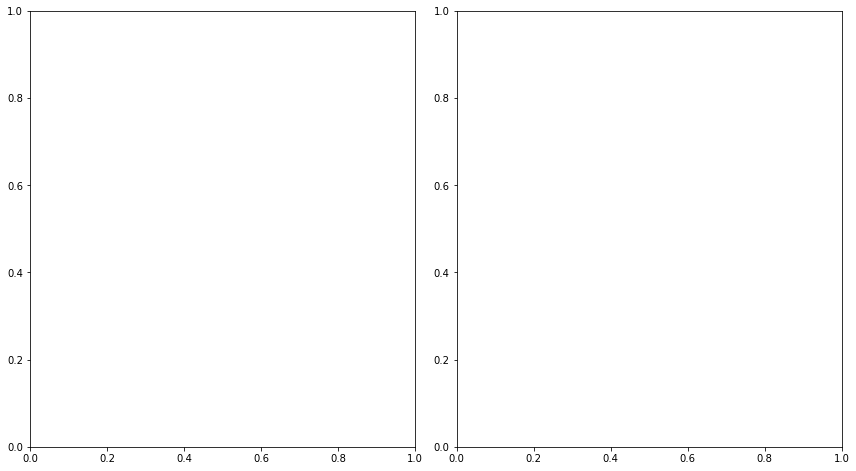

In [14]:
fig_g, ax_g = plt.subplots(1, 2)
fig_g.set_size_inches(12, 7)
fig_g.tight_layout(rect=(0, 0, 1, 0.95))

In [15]:
# call the animator. blit=True means only re-draw the parts that have changed.
anig = animation.FuncAnimation(fig_g, anigraph, frames=len(y_pred), interval=350, blit=False)
HTML(anig.to_html5_video())

- Left figure shows relation graph of the members in the karate club. M and H stand for members and heads nodes, respectively. Red nodes are Admin faction and blue nodes are Instructor faction while black nodes are incorrectly computer-labeled nodes.

- Right figure shows features plot in each epoch. Red and blue points are colored according to the ground truth.